In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [2]:
import zipfile
import os  # Import the os module

archive_path = r'/content/archive.zip'
extract_to = r'/content/DataSet'

with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extracted contents:", os.listdir(extract_to))


Extracted contents: ['dogs_set', 'cats_set']


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths to dataset directory
data_dir = '/content/DataSet'
train_dir = '/content/train'
val_dir = '/content/val'
test_dir = '/content/test'

# Create directories for train, val, test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(os.path.join(train_dir, 'cats_set'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'dogs_set'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'cats_set'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'dogs_set'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'cats_set'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'dogs_set'), exist_ok=True)

# Function to split dataset
def split_data(source_dir, train_dir, val_dir, test_dir, test_size=0.2, val_size=0.2):
    # Get the list of images for each class
    for class_name in ['cats_set', 'dogs_set']:
        class_dir = os.path.join(source_dir, class_name)
        files = os.listdir(class_dir)
        files = [f for f in files if f.endswith('.jpg') or f.endswith('.png')]  # Select image files

        # Split data into train, val, test (e.g., 80% for training, 10% for validation, 10% for test)
        train_files, temp_files = train_test_split(files, test_size=test_size + val_size, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=test_size / (test_size + val_size), random_state=42)

        # Move files to the appropriate directories
        for file in train_files:
            shutil.move(os.path.join(class_dir, file), os.path.join(train_dir, class_name, file))
        for file in val_files:
            shutil.move(os.path.join(class_dir, file), os.path.join(val_dir, class_name, file))
        for file in test_files:
            shutil.move(os.path.join(class_dir, file), os.path.join(test_dir, class_name, file))

# Split the dataset
split_data(data_dir, train_dir, val_dir, test_dir, test_size=0.2, val_size=0.2)

# Check the resulting directories (Optional)
print("Training Data (Cat):", len(os.listdir(os.path.join(train_dir, 'cats_set'))))
print("Training Data (Dog):", len(os.listdir(os.path.join(train_dir, 'dogs_set'))))
print("Validation Data (Cat):", len(os.listdir(os.path.join(val_dir, 'cats_set'))))
print("Validation Data (Dog):", len(os.listdir(os.path.join(val_dir, 'dogs_set'))))
print("Testing Data (Cat):", len(os.listdir(os.path.join(test_dir, 'cats_set'))))
print("Testing Data (Dog):", len(os.listdir(os.path.join(test_dir, 'dogs_set'))))


Training Data (Cat): 300
Training Data (Dog): 300
Validation Data (Cat): 100
Validation Data (Dog): 100
Testing Data (Cat): 100
Testing Data (Dog): 100


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32

# Data Augmentation and Preprocessing for Training Data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,       # Normalize pixel values to range [0, 1]
    rotation_range=40,       # Random rotation
    width_shift_range=0.2,   # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,         # Random shear
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    fill_mode='nearest'      # Fill missing pixels after transformations
)

# Preprocessing for Validation and Test Data (no augmentation)
val_test_datagen = ImageDataGenerator(
    rescale=1.0/255.0  # Normalize pixel values to range [0, 1]
)

# Load Training Data with Data Augmentation
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification
    classes=['cats_set', 'dogs_set']  # Specify the class order explicitly
)

# Load Validation Data
val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['cats_set', 'dogs_set']  # Specify the class order explicitly
)

# Load Test Data
test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['cats_set', 'dogs_set']  # Specify the class order explicitly
)

# Print dataset statistics
print(f"Training data batch size: {len(train_data)}")
print(f"Validation data batch size: {len(val_data)}")
print(f"Testing data batch size: {len(test_data)}")

# Inspect the class labels
print("Class labels:", train_data.class_indices)


Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Training data batch size: 19
Validation data batch size: 7
Testing data batch size: 7
Class labels: {'cats_set': 0, 'dogs_set': 1}


In [5]:
print(f"Training data batch size: {len(train_data)}")
print(f"Validation data batch size: {len(val_data)}")
print(f"Testing data batch size: {len(test_data)}")

# Inspect the class labels
print("Class labels:", train_data.class_indices)


Training data batch size: 19
Validation data batch size: 7
Testing data batch size: 7
Class labels: {'cats_set': 0, 'dogs_set': 1}


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define image dimensions and other parameters
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Define the height and width of the images
BATCH_SIZE = 32
LEARNING_RATE = 0.0001  # Custom learning rate for the Adam optimizer

# Define the model architecture
model = Sequential([

    # Convolutional Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),

    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Convolutional Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the output of convolutional layers
    Flatten(),

    # Fully Connected Layer 1
    Dense(512, activation='relu'),  # Increased number of neurons for deeper layers
    Dropout(0.5),  # Higher dropout rate for better regularization

    # Fully Connected Layer 2
    Dense(256, activation='relu'),
    Dropout(0.4),

    # Fully Connected Layer 3
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Fully Connected Layer 4
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Fully Connected Layer 5
    Dense(32, activation='relu'),
    Dropout(0.2),

    # Output Layer (binary classification)
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification (cat vs dog)
])

# Compile the model with a custom learning rate
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Model summary to view the architecture
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,113,409 (50.02 MB)

 Trainable params: 13,113,409 (50.02 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Define ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True
)


In [21]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4952 - loss: 0.6975 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5018 - loss: 0.6976 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4837 - loss: 0.7014 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5010 - loss: 0.6913 - val_accuracy: 0.4950 - val_loss: 0.6924
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4510 - loss: 0.7006 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4508 - loss: 0.6955 - val_accuracy: 0.5000 - val_loss: 0.6932


In [22]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.4924 - loss: 0.6923
Test Loss: 0.6922
Test Accuracy: 0.5000


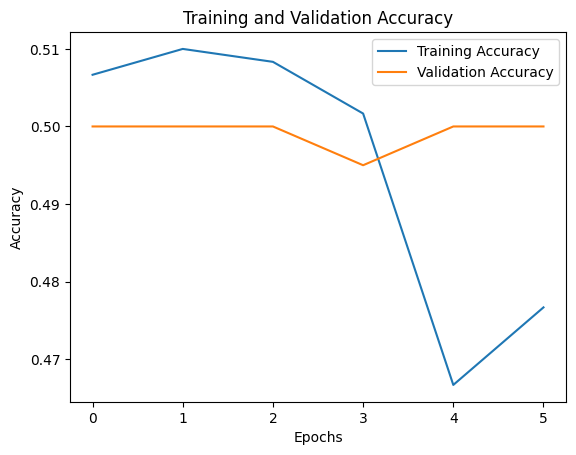

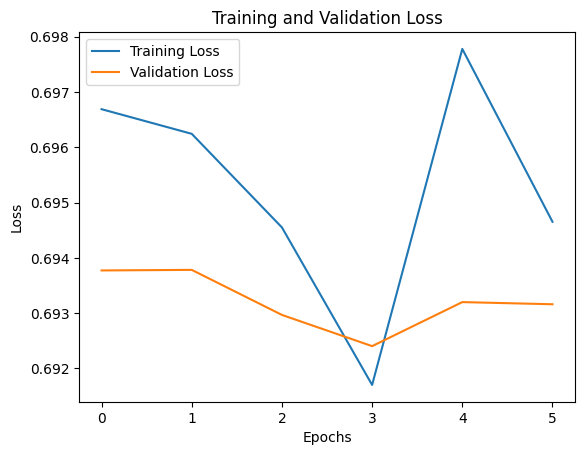

In [23]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
